In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import datetime

In [2]:
import fredapi as fa
fred = fa.Fred(api_key='b2c5d009ef385fda0a324883a24a1b75')

In [3]:
df = pd.read_csv('GOOG.csv')
df.drop('Adj Close', axis = 1, inplace = True)
df

,Date,Open,High,Low,Close,Volume
0,2018-07-03,7593.629883,7594.330078,7498.500000,7502.669922,1171420000
1,2018-07-05,7550.660156,7589.189941,7511.430176,7586.430176,1754690000
2,2018-07-06,7595.930176,7695.810059,7588.649902,7688.390137,1718600000
3,2018-07-09,7731.740234,7757.279785,7702.060059,7756.200195,1844440000
4,2018-07-10,7770.629883,7777.479980,7731.979980,7759.200195,1735230000
...,...,...,...,...,...,...
1252,2023-06-26,13468.740234,13573.570313,13334.419922,13335.780273,4430600000
1253,2023-06-27,13389.250000,13578.799805,13366.969727,13555.669922,5053660000
1254,2023-06-28,13506.019531,13654.139648,13495.730469,13591.750000,4533270000
1255,2023-06-29,13592.360352,13618.530273,13540.259766,13591.330078,4388140000


In [4]:
GDP_df = fred.get_series_as_of_date('GDP',df['Date'].iloc[-1] )
GDP_df

,realtime_start,date,value
0,1992-12-22,1946-01-01,199.7
1,1996-01-19,1946-01-01,NaT
2,1997-05-07,1946-01-01,210.4
3,1999-10-28,1946-01-01,NaT
4,1992-12-22,1946-04-01,207.7
...,...,...,...
3102,2023-02-23,2022-10-01,26144.956
3103,2023-03-30,2022-10-01,26137.992
3104,2023-04-27,2023-01-01,26465.865
3105,2023-05-25,2023-01-01,26486.287


In [5]:
df.shape

(1257, 6)

In [6]:
GDP_ = []
date1_ = []
for row in df['Date']:
    for i,r in GDP_df.iterrows():
        if str(r['date'])>str(row):
            GDP_.append(r['value'])
            date1_.append(r['realtime_start'])
            break
while (len(GDP_) != df.shape[0]):
    GDP_.append(GDP_[len(GDP_)-1])
    date1_.append(date1_[len(date1_)-1])
df['GDP'] = GDP_
df['date1'] = date1_

In [7]:
SPY_df = pd.read_csv('SPY.csv')
NASDAQ_df = pd.read_csv('NASDAQ.csv')
df['OverallValue'] = SPY_df['Close']
df['SectorValue'] = NASDAQ_df['Close']
df.drop('Date', axis = 1, inplace = True)
df.drop('date1', axis = 1, inplace = True)
df.drop('GDP', axis = 1, inplace = True)


In [8]:
def split(df):
    n_train_rows = int(df.shape[0]*.8)-1
    train = df.iloc[:n_train_rows, :]
    test = df.iloc[n_train_rows:, :]
    return train,test
splitdf = split(df)
train = splitdf[0]
test = splitdf[1]

In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
n_train = sc.fit_transform(train.values)
n_test = sc.fit_transform(test.values)

In [10]:
x_train = []
y_train = []
steps = 20

for i in range(steps, n_train.shape[0]-steps):
    x_train.append(n_train[i-steps:i, :])
    y_train.append(n_train[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(964, 20, 7)


In [11]:
x_test = []
y_test = []

for i in range(steps, n_test.shape[0]-steps):
    x_test.append(n_test[i-steps:i, :])
    y_test.append(n_test[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(213, 20, 7)


In [12]:
epochs = 30
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=x_train.shape[2]))
model.compile(loss="mse", optimizer="adam")
hist = model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary


Epoch 1/30


2023-07-10 12:37:16.384339: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 4s 26ms/step - loss: 0.0569
Epoch 2/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0146
Epoch 3/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0126
Epoch 4/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0106
Epoch 5/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0101
Epoch 6/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0090
Epoch 7/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0100
Epoch 8/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0075
Epoch 9/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0076
Epoch 10/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0073
Epoch 11/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0066
Epoch 12/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0061
Epoch 13/30
31/31 [=============================

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x11cb03e80>>

In [13]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
7/7 [==============================] - 1s 6ms/step - loss: 0.0133
test loss, test acc: 0.013329396024346352


In [14]:
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

7/7 [==============================] - 1s 6ms/step


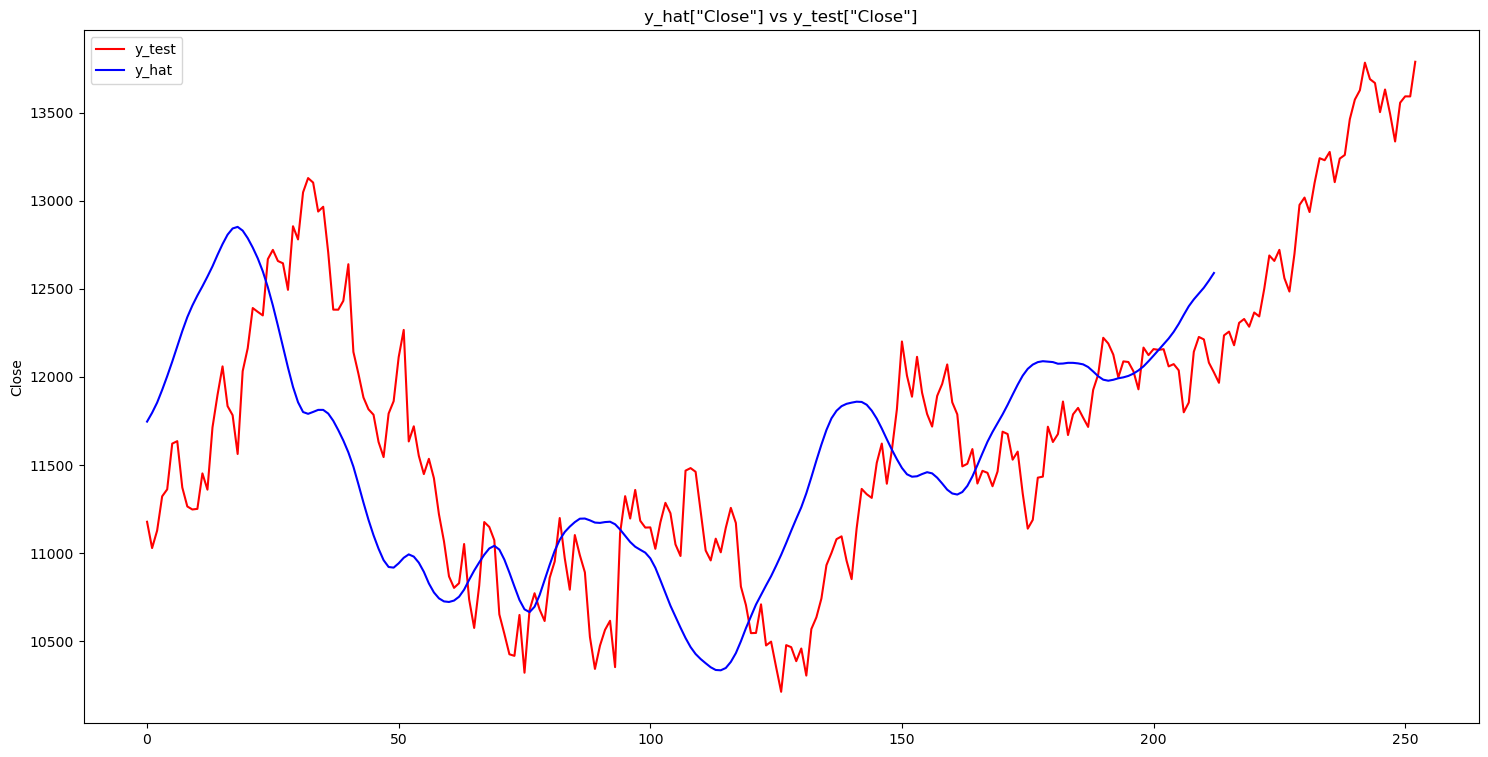

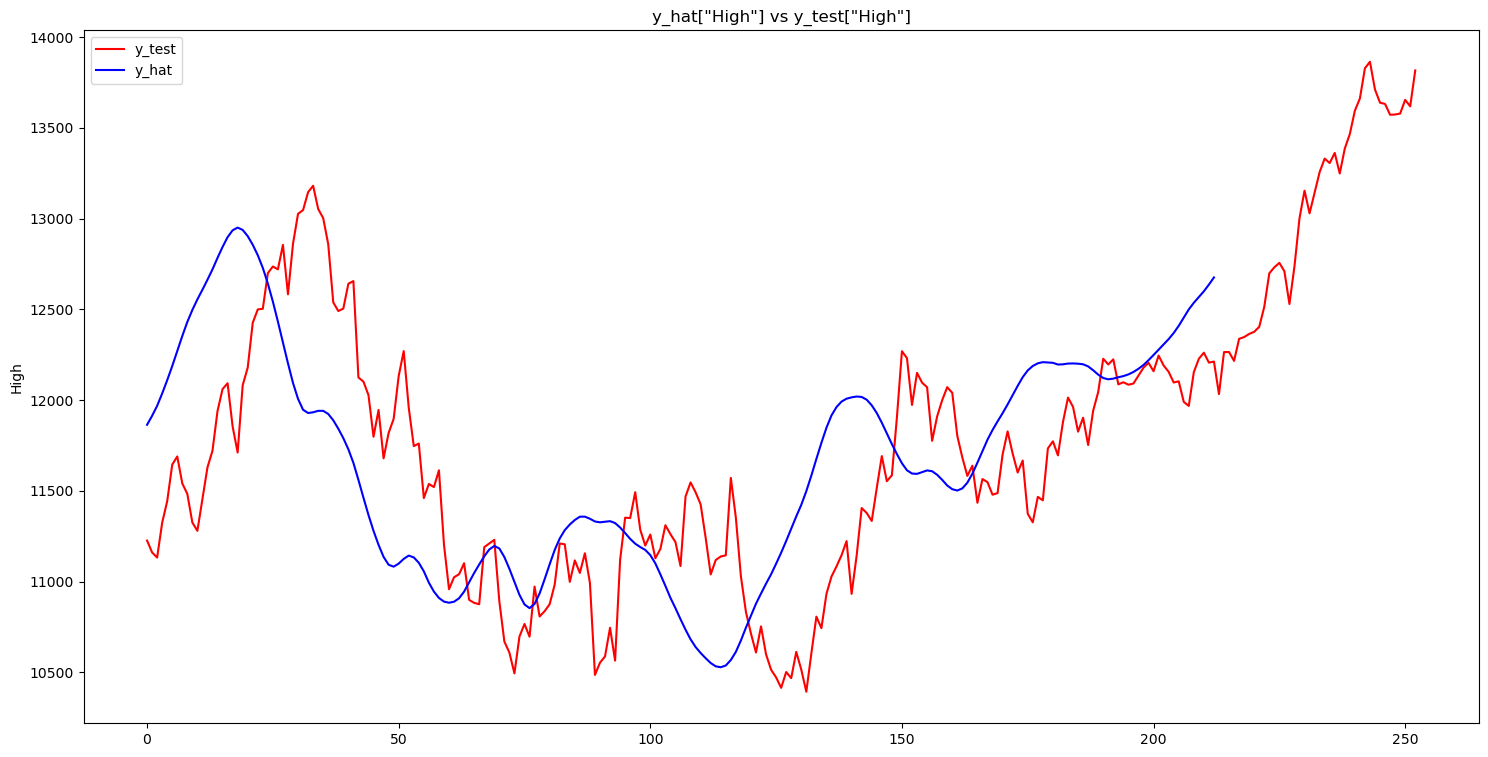

In [15]:
y_test = test.reset_index()

# Visualise the open predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['Close'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
plt.title('y_hat["Close"] vs y_test["Close"]')
plt.ylabel('Close')
plt.legend()
plt.show()

# Visualise the close predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['High'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,1], color = 'blue', label = 'y_hat')
plt.title('y_hat["High"] vs y_test["High"]')
plt.ylabel('High')
plt.legend()
plt.show()
